In [1]:
import xarray as xr
import os
import pandas as pd
import tqdm
import numpy as np
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from netCDF4 import Dataset
import cmocean

from collections import OrderedDict
from itertools import product
import math
from netCDF4 import Dataset
from cdo import *   # python version
cdo = Cdo()
import matplotlib.pylab as plt
%matplotlib inline

In [22]:
# parameters cell
input_paths = ['/p/project/chhb19/streffing1/obs/era5/netcdf/']

input_names = ['ERA5']
accumulation_period = 84600 # output frequency of OpenIFS in seconds
mass_to_heat = 'false'
exps = range(0, 1)
figsize=(6, 4.5)
dpi = 300
ofile = None

#var = ['SF']
#mapticks = [0,1,2,3,4,5,6,7,8,9,10]
var = ['ssrd', 'str', 'slhf', 'sshf']
mapticks = [-50,-30,-20,-10,-6,-2,2,6,10,20,30,50]
contour_outline_thickness = 0.1

In [23]:
def define_rowscol(input_paths, columns=len(input_paths), reduce=0):
    number_paths = len(input_paths) - reduce
#     columns = columns
    if number_paths < columns:
        ncol = number_paths
    else:
        ncol = columns
    nrows = math.ceil(number_paths / columns)
    return [nrows, ncol]

In [24]:
# Load model data

if mass_to_heat == 'true':
    m2h_factor = 333500000
else:
    m2h_factor = 1

data = OrderedDict()
for exp_path, exp_name  in zip(input_paths, input_names):
    data[exp_name] = {}
    for v in var:
        paths = []
        data[exp_name][v] = []
        for exp in tqdm.tqdm(exps):
            path = exp_path+'/srf_rad_timmean.nc'
            data[exp_name][v].append(cdo.yearmean(input="-remapcon,r360x180 "+str(path),returnArray=v)*m2h_factor/accumulation_period)

  0%|                                                                                                                                                                                        | 0/1 [00:03<?, ?it/s]

Cannot find variable 'ssrd'


LookupError: 

In [18]:
crf_sw_model = OrderedDict()
crf_sw_model_mean = OrderedDict()


for exp_name in input_names:
    for v in var:
        crf_sw_model[exp_name] = np.squeeze(data[exp_name][v])
        crf_sw_model_mean[exp_name] = np.mean(crf_sw_model[exp_name],axis=0)

In [19]:
crf_sw_model_sum = 0

for exp_name in input_names:
    for v in var:
        crf_sw_model_sum = crf_sw_model_sum + np.squeeze(data[exp_name][v]) 

convert: unable to open image 'ERA5_surface_radiation_balance': No such file or directory @ error/blob.c/OpenBlob/3533.
convert: no decode delegate for this image format `' @ error/constitute.c/ReadImage/572.
convert: no images defined `ERA5_surface_radiation_balance_trimmed.png' @ error/convert.c/ConvertImageCommand/3322.
mv: cannot stat 'ERA5_surface_radiation_balance_trimmed.png': No such file or directory


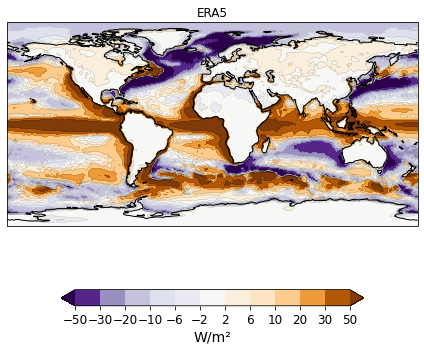

In [21]:
crf_sw_model = OrderedDict()
crf_sw_model_mean = OrderedDict()
crf_sw_model_sum = 0

for exp_name in input_names:
    for v in var:
        crf_sw_model_sum = crf_sw_model_sum + np.squeeze(data[exp_name][v]) 


lon = np.arange(0, 360, 1)
lat = np.arange(-90, 90, 1)
crf_sw_model_sum, lon = add_cyclic_point(crf_sw_model_sum, coord=lon)






nrows, ncol = define_rowscol(input_paths)
fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=figsize)
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]
i = 0


for key in input_names:

    axes[i]=plt.subplot(nrows,ncol,i+1,projection=ccrs.PlateCarree())
    axes[i].add_feature(cfeature.COASTLINE,zorder=3)
    
    
    imf=plt.contourf(lon, lat, crf_sw_model_sum, cmap='PuOr_r', 
                     levels=mapticks, extend='both',
                     transform=ccrs.PlateCarree(),zorder=1)
    line_colors = ['black' for l in imf.levels]
    imc=plt.contour(lon, lat, crf_sw_model_sum, colors=line_colors, 
                    levels=mapticks, linewidths=contour_outline_thickness,
                    transform=ccrs.PlateCarree(),zorder=1)

    axes[i].set_ylabel('W/m²')
    
    axes[i].set_title(key)
    plt.tight_layout() 

    i = i+1
    
    cbar_ax_abs = fig.add_axes([0.15, -0.06, 0.7, 0.05])
    cbar_ax_abs.tick_params(labelsize=12)
    cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal',ticks=mapticks)
    cb.set_label(label="W/m²", size='14')
    cb.ax.tick_params(labelsize='12')

ofile='ERA5_surface_radiation_balance'
    
if ofile is not None:
    plt.savefig(ofile, dpi=dpi)
    os.system(f'convert {ofile} -trim {ofile}_trimmed.png')
    os.system(f'mv {ofile}_trimmed.png {ofile}')